In [1]:
import pandas as pd
#Google colab does not have pickle
try:
  import pickle5 as pickle
except:
  !pip install pickle5
  import pickle5 as pickle
import os
import seaborn as sns
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D,Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding,  Concatenate, Lambda
from keras.models import Model
from sklearn.metrics import roc_auc_score,confusion_matrix,roc_curve, auc
from numpy import random
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

import sys
sys.path.insert(0,'/content/drive/MyDrive/ML_Data/')
import functions as f

     |████████████████████████████████| 133kB 12.6MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219252 sha256=9614ff5be835cee496a903fb3f5520b6b583d55db2ca6604939123f8efa1b842
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


In [2]:
def load_data(D=1,randomize=False):
    try:
        with open('/content/drive/MyDrive/ML_Data/df_train_'+str(D)+'D.pickle', 'rb') as handle:
            df_train = pickle.load(handle)
    except:
        df_train = pd.read_pickle("C:/Users/nik00/py/proj/hyppi-train.pkl")
    try:
        with open('/content/drive/MyDrive/ML_Data/df_test_'+str(D)+'D.pickle', 'rb') as handle:
            df_test = pickle.load(handle)
    except:
        df_test = pd.read_pickle("C:/Users/nik00/py/proj/hyppi-independent.pkl")
    if randomize:
        return shuff_together(df_train,df_test)
    else:
        return df_train,df_test

df_train,df_test = load_data(4)
print('The data used will be:')
df_train[['Human','Yersinia']]

The data used will be:


,Human,Yersinia
0,"[MKDK, KDKQ, DKQK, KQKK, QKKK, KKKK, KKKE, KKE...","[MAKA, AKAS, KASR, ASRH, SRHN, RHNL, HNLS, NLS..."
1,"[MSWS, SWSG, WSGL, SGLL, GLLH, LLHG, LHGL, HGL...","[MQHV, QHVT, HVTG, VTGS, TGSK, GSKR, SKRR, KRR..."
2,"[MSLF, SLFD, LFDL, FDLF, DLFR, LFRG, FRGF, RGF...","[MAEL, AELP, ELPA, LPAK, PAKR, AKRR, KRRF, RRF..."
3,"[MAVA, AVAP, VAPR, APRL, PRLF, RLFG, LFGG, FGG...","[MRIF, RIFA, IFAI, FAIS, AISC, ISCS, SCSS, CSS..."
4,"[MSTI, STIQ, TIQS, IQSE, QSET, SETD, ETDC, TDC...","[MSYA, SYAF, YAFP, AFPG, FPGT, PGTF, GTFP, TFP..."
...,...,...
6265,"[MSYF, SYFG, YFGE, FGEH, GEHF, EHFW, HFWG, FWG...","[MITT, ITTD, TTDG, TDGN, DGNS, GNSA, NSAV, SAV..."
6266,"[MTVG, TVGK, VGKS, GKSS, KSSK, SSKM, SKML, KML...","[MSQP, SQPP, QPPF, PPFW, PFWQ, FWQQ, WQQK, QQK..."
6267,"[MNNL, NNLS, NLSF, LSFS, SFSE, FSEL, SELC, ELC...","[MSED, SEDR, EDRH, DRHQ, RHQQ, HQQR, QQRQ, QRQ..."
6268,"[MAPE, APEI, PEIN, EINL, INLP, NLPG, LPGP, PGP...","[MKNL, KNLS, NLSF, LSFV, SFVA, FVAG, VAGL, AGL..."


Median length of Human sequence is 476


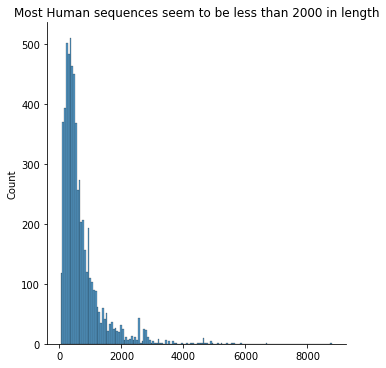

In [ ]:
lengths = sorted(len(s) for s in df_train['Human'])
print("Median length of Human sequence is",lengths[len(lengths)//2])
_  = sns.displot(lengths)
_=plt.title("Most Human sequences seem to be less than 2000 in length")

Median length of Yersinia sequence is 333


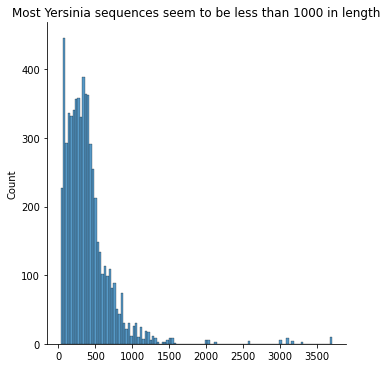

In [ ]:
lengths = sorted(len(s) for s in df_train['Yersinia'])
print("Median length of Yersinia sequence is",lengths[len(lengths)//2])
_  = sns.displot(lengths)
_=plt.title("Most Yersinia sequences seem to be less than 1000 in length")

MAX_VOCAB_SIZE is 100000
MAX_SEQUENCE_LENGTH is 1000
max sequences1_train length: 8063
min sequences1_train length: 34
median sequences1_train length: 440


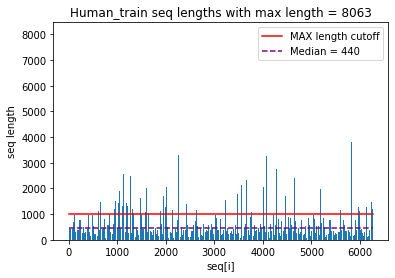

max word index sequences1_train: 99999
max sequences2_train length: 3707
min sequences2_train length: 26
median sequences2_train length: 320


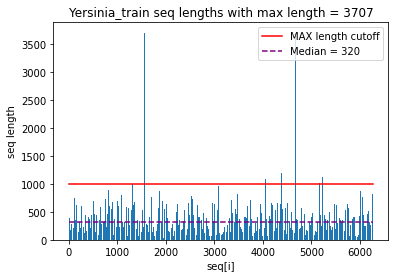

max word index sequences2_train: 99999
Found 155225 unique tokens in tokenizer1.
Found 134906 unique tokens in tokenizer2.
pre padding
Shape of data1 tensor: (6270, 1000)
Shape of data2 tensor: (6270, 1000)
max test_sequences1 length: 5224
min test_sequences1 length: 34
median test_sequences1 length: 449


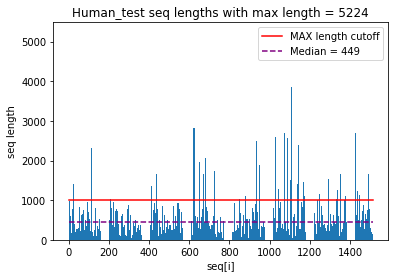

max test_sequences2 length: 3707
min test_sequences2 length: 24
median test_sequences2 length: 308


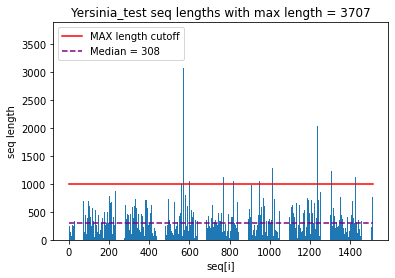

pre padding for test seq.
Shape of test_data1 tensor: (1514, 1000)
Shape of test_data2 tensor: (1514, 1000)
num_words is 100000


In [3]:
data1_4D_doubleip_pre,data2_4D_doubleip_pre,data1_test_4D_doubleip_pre,data2_test_4D_doubleip_pre,num_words_4D,MAX_SEQUENCE_LENGTH_4D,MAX_VOCAB_SIZE_4D = f.get_seq_data_doubleip(100000,1000,df_train,df_test,pad = 'pre', show=True)

In [ ]:
data1_4D_doubleip_center,data2_4D_doubleip_center,data1_test_4D_doubleip_center,data2_test_4D_doubleip_center,num_words_4D,MAX_SEQUENCE_LENGTH_4D,MAX_VOCAB_SIZE_4D = f.get_seq_data_doubleip(100000,1000,df_train,df_test)

MAX_VOCAB_SIZE is 100000
MAX_SEQUENCE_LENGTH is 1000
max sequences1_train length: 8063
min sequences1_train length: 34
median sequences1_train length: 440
max word index sequences1_train: 99999
max sequences2_train length: 3707
min sequences2_train length: 26
median sequences2_train length: 320
max word index sequences2_train: 99999
Found 155225 unique tokens in tokenizer1.
Found 134906 unique tokens in tokenizer2.
Center padding
Shape of data1 tensor: (6270, 1000)
Shape of data2 tensor: (6270, 1000)
max test_sequences1 length: 5224
min test_sequences1 length: 34
median test_sequences1 length: 449
max test_sequences2 length: 3707
min test_sequences2 length: 24
median test_sequences2 length: 308
Center padding for test seq.
Shape of test_data1 tensor: (1514, 1000)
Shape of test_data2 tensor: (1514, 1000)
num_words is 100000


In [ ]:
data1_4D_doubleip_post,data2_4D_doubleip_post,data1_test_4D_doubleip_post,data2_test_4D_doubleip_post,num_words_4D,MAX_SEQUENCE_LENGTH_4D,MAX_VOCAB_SIZE_4D = f.get_seq_data_doubleip(100000,1000,df_train,df_test,pad = 'post')

MAX_VOCAB_SIZE is 100000
MAX_SEQUENCE_LENGTH is 1000
max sequences1_train length: 8063
min sequences1_train length: 34
median sequences1_train length: 440
max word index sequences1_train: 99999
max sequences2_train length: 3707
min sequences2_train length: 26
median sequences2_train length: 320
max word index sequences2_train: 99999
Found 155225 unique tokens in tokenizer1.
Found 134906 unique tokens in tokenizer2.
post padding
Shape of data1 tensor: (6270, 1000)
Shape of data2 tensor: (6270, 1000)
max test_sequences1 length: 5224
min test_sequences1 length: 34
median test_sequences1 length: 449
max test_sequences2 length: 3707
min test_sequences2 length: 24
median test_sequences2 length: 308
post padding for test seq.
Shape of test_data1 tensor: (1514, 1000)
Shape of test_data2 tensor: (1514, 1000)
num_words is 100000


In [ ]:


EMBEDDING_DIM_4D = 10
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 15
DROP=0.5

x1 = f.conv_model(MAX_SEQUENCE_LENGTH_4D,EMBEDDING_DIM_4D,num_words_4D,DROP)
x2 = f.conv_model(MAX_SEQUENCE_LENGTH_4D,EMBEDDING_DIM_4D,num_words_4D,DROP)
x3 = f.conv_model(MAX_SEQUENCE_LENGTH_4D,EMBEDDING_DIM_4D,num_words_4D,DROP)
x4 = f.conv_model(MAX_SEQUENCE_LENGTH_4D,EMBEDDING_DIM_4D,num_words_4D,DROP)
x5 = f.conv_model(MAX_SEQUENCE_LENGTH_4D,EMBEDDING_DIM_4D,num_words_4D,DROP)
x6 = f.conv_model(MAX_SEQUENCE_LENGTH_4D,EMBEDDING_DIM_4D,num_words_4D,DROP)

concatenator = Concatenate(axis=1)
x = concatenator([x1.output, x2.output, x3.output, x4.output, x5.output, x6.output])
x = Dense(128)(x)
x = Dropout(0.3)(x)
output = Dense(1, activation="sigmoid",name="Final")(x)
model4D_CNN_doubleip = Model(inputs=[x1.input, x2.input, x3.input, x4.input, x5.input, x6.input], outputs=output)

model4D_CNN_doubleip.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#plot_model(model4D_CNN_doubleip, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

trains = [data1_4D_doubleip_pre,data2_4D_doubleip_pre,data1_4D_doubleip_center,data2_4D_doubleip_center,data1_4D_doubleip_post,data2_4D_doubleip_post]
tests = [data1_test_4D_doubleip_pre,data2_test_4D_doubleip_pre,data1_test_4D_doubleip_center,data2_test_4D_doubleip_center,data1_test_4D_doubleip_post,data2_test_4D_doubleip_post]


model4D_CNN_doubleip.fit(trains, df_train['label'].values, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(tests, df_test['label'].values))
print(roc_auc_score(df_test['label'].values, model4D_CNN_doubleip.predict(tests)))

#asd


Epoch 1/15
49/49 [==============================] - 27s 166ms/step - loss: 0.6620 - accuracy: 0.6198 - val_loss: 0.5416 - val_accuracy: 0.7239
Epoch 2/15
49/49 [==============================] - 7s 153ms/step - loss: 0.4765 - accuracy: 0.7702 - val_loss: 0.4382 - val_accuracy: 0.8078
Epoch 3/15
49/49 [==============================] - 7s 152ms/step - loss: 0.1674 - accuracy: 0.9437 - val_loss: 0.4269 - val_accuracy: 0.8236
Epoch 4/15
49/49 [==============================] - 8s 154ms/step - loss: 0.0558 - accuracy: 0.9850 - val_loss: 0.4621 - val_accuracy: 0.8236
Epoch 5/15
49/49 [==============================] - 7s 151ms/step - loss: 0.0184 - accuracy: 0.9953 - val_loss: 0.6043 - val_accuracy: 0.8151
Epoch 6/15
49/49 [==============================] - 7s 152ms/step - loss: 0.0216 - accuracy: 0.9937 - val_loss: 0.6085 - val_accuracy: 0.8144
Epoch 7/15
49/49 [==============================] - 7s 151ms/step - loss: 0.0100 - accuracy: 0.9975 - val_loss: 0.6282 - val_accuracy: 0.8157
Epoch